In [1]:
import pandas as pd
import numpy as np
import operator 
import re

import time 
import gc 

np.random.seed(42)

from keras.models import Model
from keras.layers import Input, Dropout, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional,LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
from keras import backend as K
from keras.models import Model

from keras import optimizers

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['OMP_NUM_THREADS'] = '24'

import re
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tqdm import tqdm

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../avito_test/train.csv')
#test = pd.read_csv('../avito_test/test.csv')
#df = pd.concat([train ,test])
df = train
print("Number of texts: ", df.shape[0])


Number of texts:  489517


In [3]:
df['text'] = df['title'] + ' '+ df['description'] 

In [4]:
EMBEDDING_DIM = 300
EMBEDDING_FILE = '../avito_test/cc.ru.300.vec'
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [5]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [6]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [7]:
vocab = build_vocab(df['text'])

In [8]:
print("FastText : ")
oov_fasttext = check_coverage(vocab, embeddings_index)

FastText : 
Found embeddings for 23.25% of vocab
Found embeddings for  80.94% of all text


In [9]:
oov_fasttext[:10]

[('состоянии,', 21670),
 ('б/у', 11750),
 ('см,', 9816),
 ('!!!', 7097),
 ('Цвет:', 6677),
 ('мм,', 6007),
 ('Материал:', 5908),
 ('100%', 5794),
 ('товара:', 5623),
 ('Вес:', 5621)]

In [10]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [11]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

In [12]:
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }


In [13]:
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'▼':'', '®':'', '🌴':'', '→→→':' ', '❗':' ', '📌': '', '💰': ' ', '👍': ' ', '🌞':' ', '✔': '', '►': ' ', '⇒⇒⇒⇒⇒⇒⇒⇒⇒⇒⇒⇒⇒⇒': ' ', '➜➜': ' ', '✅':' ', '\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [14]:
df['text'] = df['text'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))

In [15]:
vocab = build_vocab(df['text'])
oov_fasttext = check_coverage(vocab, embeddings_index)

Found embeddings for 54.80% of vocab
Found embeddings for  97.98% of all text


In [16]:
oov_fasttext[:10]

[('мА⋅ч', 2488),
 ('РегионГолд', 1520),
 ('kubcirkonii', 581),
 ('webitemaddadditemalltesttestitemalltest', 511),
 ('pseudopectinatus', 416),
 ('LP156WH2', 348),
 ('№00', 342),
 ('№1', 340),
 ('LP154W01', 329),
 ('асорттимент', 324)]

In [17]:
mispell_dict = {'оцинковать': 'оцинковывать','ботильон':'ботинки ', 'Недрагоценные':'не драгоценные','лфз':'императорский фарфоровый завод','pseudopectinatus':'кактус', 'асорттимент':'ассортимент','мА⋅ч': 'миллиампер-час', 'мА·ч':'миллиампер-час', 'РегионГолд':'ювелирный магазин','kubcirkonii':'ювелирные украшения'}


In [18]:
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [19]:
df['text'] = df['text'].apply(lambda x: correct_spelling(x, mispell_dict))
df['text'] = df['text'].apply(lambda x: re.sub(' +', ' ', x))
vocab = build_vocab(df['text'])
oov_fasttext = check_coverage(vocab, embeddings_index)

Found embeddings for 54.80% of vocab
Found embeddings for  98.00% of all text


In [20]:
EMBEDDING_FILE_2 = '../crawl-300d-2M.vec'
embeddings_index_2 = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE_2))

In [21]:
def add_eng(embedding1, embedding2):
    count = 0
    for word in embedding2:
        if word not in embedding1 :  
            embedding1[word] = embedding2[word]
            count += 1
    print(f"Added {count} words to embedding")

In [22]:
add_eng(embeddings_index, embeddings_index_2)

Added 1766419 words to embedding


In [23]:
oov_fasttext = check_coverage(vocab, embeddings_index)

Found embeddings for 58.32% of vocab
Found embeddings for  98.23% of all text


In [24]:
df.head()

,item_id,title,description,price,category_id,text
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19,Картина Гобелен . Размеры 139х84см .
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22,Стулья из прессованной кожи Продам недорого 4 ...
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37,Домашняя мини баня Мини баня МБ - 1 ( мини сау...
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43,"Эксклюзивная коллекция книг "" Трансаэро "" + по..."
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1,Ноутбук aser Продаётся ноутбук ACER e5 - 511C2...


In [134]:

df_x_train = pd.read_csv('../avito_test/prep_dataset.csv')
#df_y_train = train['category_id']

df_y_train = df_x_train['category_id']

In [110]:
df_x_train.head()

,Unnamed: 0,item_id,title,description,price,category_id,preproc1_des,preproc1_tit,preproc2_des,preproc2_tit,...,price_45_log_nrm,price_50_log_nrm,price_55_log_nrm,price_60_log_nrm,price_70_log_nrm,price_80_log_nrm,price_90_log_nrm,price_99_log_nrm,price_100_log_nrm,text
0,0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19,гобелен размер 139х84см,картина,гобелен_S размер_S 139х84см_UNKN,картина_S,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,картина гобелен размер 139х84см
1,1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22,продавать недорого 4 стул из светлый прессован...,стул из прессованный кожа,продавать_V недорого_ADV 4_UNKN стул_S из_PR с...,стул_S из_PR прессованный_A кожа_S,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,стул из прессованный кожа продавать недорого 4...
2,2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37,мини баня мб 1 мини сауна предназначать для пр...,домашний мини баня,мини_COM баня_S мб_S 1_UNKN мини_COM сауна_S п...,домашний_A мини_COM баня_S,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.972519,0.000000,0.0,домашний мини баня мини баня мб 1 мини сауна п...
3,3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43,продавать эксклюзивный коллекция книга выпуска...,эксклюзивный коллекция книга трансаэро подарок,продавать_V эксклюзивный_A коллекция_S книга_S...,эксклюзивный_A коллекция_S книга_S трансаэро_S...,...,0.0,0.0,0.0,0.0,0.963024,0.0,0.000000,0.000000,0.0,эксклюзивный коллекция книга трансаэро подарок...
4,4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1,прод тся ноутбук acer e5 511c2ta купить в коне...,ноутбук aser,прод_S тся_S ноутбук_S acer_UNKN e5_UNKN 511c2...,ноутбук_S aser_UNKN,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.873452,0.0,ноутбук aser прод тся ноутбук acer e5 511c2ta ...


In [135]:
df_x_train['text'] = df_x_train['preproc1_tit'] + ' '+ df_x_train['preproc1_des'] 

In [136]:
df_x_train['text'] = df_x_train['text'].astype(str)

In [137]:
import argparse
config = argparse.Namespace()

In [138]:
price = np.log1p(df_x_train['price'])

In [139]:
config.len_text = 100000

In [140]:
from keras.preprocessing.text import Tokenizer
tokenizer_text = Tokenizer(num_words = config.len_text, lower = False)
tokenizer_text.fit_on_texts(df_x_train['text'].values)
tr_desc_seq = tokenizer_text.texts_to_sequences(df_x_train['text'].values)


In [141]:
config.maxlen= 150

In [142]:
tr_desc_pad = pad_sequences(tr_desc_seq, maxlen=config.maxlen)

In [143]:
valid_idx = df_x_train.sample(frac=0.1, random_state=42).index
train_idx = df_x_train[np.invert(df_x_train.index.isin(valid_idx))].index

In [144]:
from keras.utils import np_utils
X = np.array([price])
Y = np_utils.to_categorical(df_y_train)

In [145]:
X_train = [x[train_idx] for x in X]
X_valid = [x[valid_idx] for x in X]

In [146]:
Y_train = Y[train_idx]
Y_valid = Y[valid_idx]

In [147]:
X_train.append(tr_desc_pad[train_idx])
X_valid.append(tr_desc_pad[valid_idx])

In [148]:
vocab_size = len(tokenizer_text.word_index)+2
EMBEDDING_DIM = 300# this is from the pretrained vectors
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

# Creating Embedding matrix 
w_Y = []
w_No = []
for word, i in tokenizer_text.word_index.items():
    if word in embeddings_index:
        embedding_vector = embeddings_index[word]
        w_Y.append(word)
    else:
        embedding_vector = None
        w_No.append(word)
    if embedding_vector is not None:    
        embedding_matrix[i] = embedding_vector

print(f'word not in texts: {len(w_No)}, words in texts: {len(w_Y)}')
print(f'embedding matrix shape: {embedding_matrix.shape}')


word not in texts: 219505, words in texts: 118908
embedding matrix shape: (338415, 300)


In [149]:
config.batch_size = 4096

In [150]:
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [161]:
def get_model():
    K.clear_session()
    
    #price
    inp_price = Input(shape=(1, ), name='inp_price')
    emb_price = Dense(14, activation='tanh', name='emb_price')(inp_price)

    # text
    inp_text = Input(shape=(config.maxlen, ), name='inp_text')
    emb_text = Embedding(vocab_size, EMBEDDING_DIM, 
                            weights = [embedding_matrix],trainable = True)(inp_text)
                                          
    
    emb_text = SpatialDropout1D(0.2) (emb_text)
    
    rnn_layer = Bidirectional(LSTM(50, dropout=0.25, recurrent_dropout=0.25, return_sequences=True))(emb_text)
    rnn_layer = Attention(config.maxlen) (rnn_layer)
    
    conc = concatenate([emb_price, rnn_layer], axis=-1)
    
    main = Dropout(0.2)(Dense(80,activation='relu') (conc))

    outp = Dense(54, activation='sigmoid', name='output')(main)

    model = Model(inputs = [inp_price, inp_text], outputs = outp)
    return model

In [162]:
model = get_model()
model.compile(optimizer = 'adam',
              loss= 'categorical_crossentropy',
              metrics = ['categorical_accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_text (InputLayer)           (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 300)     101524500   inp_text[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 150, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
inp_price (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
bidirectio

In [163]:
checkpoint = ModelCheckpoint('best_rnn.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
early = EarlyStopping(patience=3, mode='min')

In [164]:
history = model.fit(x=X_train, y=Y_train, validation_data=(X_valid, Y_valid), batch_size=config.batch_size, 
          epochs=12, callbacks=[early, checkpoint], verbose=1)

Train on 433813 samples, validate on 48202 samples
Epoch 1/12
433813/433813 [==============================] - 727s 2ms/step - loss: 3.5030 - categorical_accuracy: 0.0915 - val_loss: 2.3581 - val_categorical_accuracy: 0.4168
Epoch 2/12
433813/433813 [==============================] - 712s 2ms/step - loss: 1.7860 - categorical_accuracy: 0.4809 - val_loss: 0.8627 - val_categorical_accuracy: 0.7911
Epoch 3/12
433813/433813 [==============================] - 706s 2ms/step - loss: 0.8581 - categorical_accuracy: 0.7737 - val_loss: 0.5627 - val_categorical_accuracy: 0.8525
Epoch 4/12
433813/433813 [==============================] - 707s 2ms/step - loss: 0.5948 - categorical_accuracy: 0.8435 - val_loss: 0.4877 - val_categorical_accuracy: 0.8672
Epoch 5/12
433813/433813 [==============================] - 712s 2ms/step - loss: 0.4919 - categorical_accuracy: 0.8672 - val_loss: 0.4551 - val_categorical_accuracy: 0.8739
Epoch 6/12
433813/433813 [==============================] - 718s 2ms/step - los

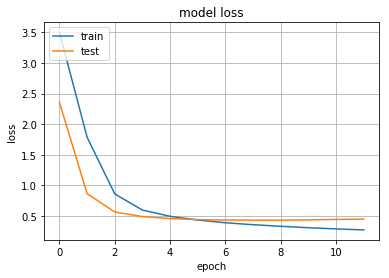

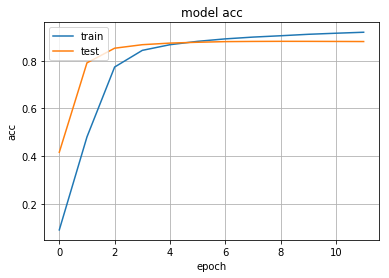

In [165]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()
# summarize history for loss
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()